In [1]:
import sys 
import os
import cobra
import cplex 
import libsbml
import copy
from pathlib import Path
import memote
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import path 
import pandas as pd
import numpy as np
from scipy.stats import zscore
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu
import multiprocessing
from itertools import combinations, product
from multiprocessing import Pool
from sklearn.decomposition import PCA
import mplcursors
import math
import itertools


from sklearn.linear_model  import LinearRegression

#Change working dir first, ty ChatGPT, much loves
cwd = os.getcwd()
# Split the path into a list of directories
directories = cwd.split(os.sep)
# Remove the last two directories from the list
directories = directories[:-2]
# Join the directories back into a path
new_cwd = os.sep.join(directories)
# Change the current working directory to the new path
os.chdir(new_cwd)

sys.path.append("./src/")

import model_initialize as mi
import model_manipulation as mm


#Set solver to gurobi
config = cobra.Configuration()
config.solver = 'gurobi'

#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6


#Add trans reactions to trans_model
mi.add_trans_reactions(trans_model)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-09


Pipeline breakdown:

Load CSVs to a memory saving format first

1.
Run convergence statistics on each and generate plots to assess total convergence stats for each CSV. These will include tests such as the Geweke statistic. 
Afterwards get only the flux names of those reactions that have converged
Run pairwise Kruskal-wallis tests per CSV using the above list of converged reactions
Identify each reaction with significant and non-significant distributions each

Generate histograms/probability densities for relevant reactions with significantly different distributions with WT and Trans models

2. Flux coupling analysis
Check which fluxes are coupled with each otehr and identify which fluxes are then related to each other, particularly Carbon Fixation reactions in the BS cell such as Rubisco and the DM_Phloem reactions. 


Visualization of fluxes
1. Violin plots for each constituent reaction group showing WT and TR per light parameter
2. 


In [4]:
'''This code block contains functions that we need to use to analyze our flux sampling experiment. 
These include tests to check for convergence, for autocorrelation, as well as for pairwise comparisons of fluxes between
parametization regimens (WT, TR, as well as 3 light conditions) and a script to determine whether fluxes are
coupled with each other. Lastly, I also tried PCA to determine which reactions contribute most to the variance of each null space distribution per
sampling run.
'''

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name


def load_csv_and_cleanup(filename, tol=1e-7):
    # Load the CSV file
    df = pd.read_csv(filename)

    # Remove columns with a mean below tolerance
    mean_values = df.mean()
    columns_to_remove = mean_values[abs(mean_values) < tol].index
    df = df.drop(columns=columns_to_remove)

    # Fix the indices
    df.reset_index(drop=True, inplace=True)
    print(df.shape)

    return df    

    


def compare_pair(reaction, df1, df2, significance_threshold):
    """
    Compare the flux distributions of a pair of columns from two dataframes using the Kruskal-Wallis test.

    :param pair: Tuple containing the pair of column names.
    :param df1: The first dataframe.
    :param df2: The second dataframe.
    :param significance_threshold: The significance threshold to use for the Kruskal-Wallis test.
    :return: The pair and the result of the Kruskal-Wallis test.
    """
    sample1 = df1[reaction]
    sample2 = df2[reaction]
    H, pval = kruskal(sample1, sample2)
    return pval 

def compare_flux_distributions(df1, df2, significance_threshold=0.05):
    """
    Compare the flux distributions of each pair of columns from two dataframes using the Kruskal-Wallis test.

    :param df1: The first dataframe.
    :param df2: The second dataframe.
    :param significance_threshold: The significance threshold to use for the Kruskal-Wallis test (default: 0.05).
    :return: A list of pairs with significantly different distributions.
    """
    common_columns = set(df1.columns) & set(df2.columns)
    
    pool = multiprocessing.Pool()
    sig_results = []
    non_sig_results = []
    
    for rxn in common_columns:
        kw_pval = compare_pair(rxn, df1, df2, significance_threshold) #This does the Kruskal-Wallis part
        if kw_pval < significance_threshold:
            sig_results.append(rxn)
        else:
            non_sig_results.append(rxn)
            
    #Sort the outputs before returning
    sig_results.sort()
    non_sig_results.sort()
            
    
    return sig_results, non_sig_results



#The script above is used for flux coupling using the opened CSV file as input and outputs 3 lists:
#positively correlated, neg. correlated and uncoupled reactions


#This is for visualization
def generate_histograms(dataframe1, dataframe2, column_name):
    # Create subplots for two histograms
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Histogram for dataframe1
    axes[0].hist(dataframe1[column_name], bins=10, color='skyblue')
    axes[0].set_title(f'Histogram of {column_name}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Frequency')

    # Histogram for dataframe2
    axes[1].hist(dataframe2[column_name], bins=10, color='lightgreen')
    axes[1].set_title(f'Histogram of {column_name}')
    axes[1].set_xlabel(column_name)
    axes[1].set_ylabel('Frequency')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the histograms
    plt.show()

    
def generate_stacked_histogram(dataframes, column_name,histtype='bar'):
    fig = plt.figure()
    
    # Concatenate the column data from all dataframes into a single series
    
    df_name = list()
    
    
    for dfs in dataframes:
    # Create the stacked histogram
        if column_name in dfs.columns:

            plt.hist(dfs[column_name], bins=33, alpha=0.45, stacked=True, density=False,histtype=histtype)
            df_name.append(get_df_name(dfs))
        else:
            pass
    
    
    
    
    # Set plot title and labels
    plt.title(f"Stacked Histogram for Column: {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Counts")
    plt.legend(df_name)
 
    
    plt.figure().set_figheight(1)
    
    return fig

def plot_scatter_regression(df, column_x, column_y):
    """
    Generates a scatterplot and a linear regression line between two columns in a dataframe.

    Parameters:
        - df (pandas.DataFrame): The input dataframe.
        - column_x (str): The column name for the X-axis.
        - column_y (str): The column name for the Y-axis.
    """

    # Extract X and Y values from the dataframe
    X = df[column_x].values.reshape(-1, 1)
    Y = df[column_y].values

    # Fit linear regression model
    regression = LinearRegression()
    regression.fit(X, Y)

    # Predict Y values based on the regression line
    Y_pred = regression.predict(X)

    # Plot the scatterplot and regression line
    plt.scatter(X, Y, color='blue', label='Actual')
    plt.plot(X, Y_pred, color='red', label='Regression Line')
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.title('Scatterplot with Linear Regression Line')
    plt.legend()
    plt.show()


    
    
#These functions are for generating PCA plots and other corollary analyses

def merge_dataframes(dataframes, names):
    merged_df = pd.DataFrame()
    
    for i, df in enumerate(dataframes):
        # Get the corresponding name from the names list
        df_name = names[i]
        
        # Add a new column with the dataframe name
        df['sample'] = df_name
        
        # Merge dataframes
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # Remove NAs
    merged_df = merged_df.fillna(1e-7)
    
    return merged_df

def generate_pca_plot(dataframe):
    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns
    X = dataframe[numeric_columns].values

    pca = PCA(n_components=3)

    components = pca.fit_transform(X)

    # Extract dataframe names
    dataframe_names = dataframe['sample'].unique()

    # Generate plot with different colors for each dataframe
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']  # Add more colors if needed

    #Generate figure and subplot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, name in enumerate(dataframe_names):
        indices = dataframe['sample'] == name
        ax.scatter(components[indices, 0], components[indices, 1], label=name, c=colors[i])

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    
    mplcursors.cursor(hover=True)
    plt.show()
 
    #export PCA to determine component variance
    
    pca_fit = pca.fit(X)
    
    return pca_fit

def select_significant_features(pca, feature_names, top_n):
    loadings = pca.components_
    abs_loadings = np.abs(loadings)
    feature_contribution = np.sum(abs_loadings, axis=0)
    sorted_features = feature_names[np.argsort(feature_contribution)[::-1]]
    selected_features = sorted_features[:top_n]
    return selected_features

def plot_selected_features_heatmap(pca, feature_names, selected_features):
    loadings = pca.components_
    selected_indices = [np.where(feature_names == feature)[0][0] for feature in selected_features]
    selected_loadings = loadings[:, selected_indices]

    plt.figure(figsize=(10, 6))
    sns.heatmap(selected_loadings, cmap='coolwarm', annot=False, xticklabels=selected_features)
    plt.xlabel('Selected Features')
    plt.ylabel('Principal Components')
    plt.title('Loadings Heatmap of Selected Features')
    plt.show()


    
def visualize_correlation_matrix(df, sort_by=None, ascending=False):
    """
    Calculates and visualizes the correlation matrix based on flux measurements in a dataframe.

    Parameters:
        - df (pandas.DataFrame): The input dataframe containing flux measurements.
        - sort_by (str or None): Column name to sort the correlation matrix by. Default is None.
        - ascending (bool): Whether to sort in ascending order. Default is False.
    """

    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Sort the correlation matrix if sort_by is specified
    if sort_by is not None:
        correlation_matrix = correlation_matrix.sort_values(by=sort_by, ascending=ascending)

    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

    # Set plot title
    plt.title('Correlation Matrix')

    # Display the heatmap
    plt.show()

def filter_correlation_pairs(correlation_matrix, threshold, filter_elements):
    """
    Filters out specific pairs in the correlation matrix based on a specified absolute value threshold,
    removes pairs that share columns, removes symmetrical results, and returns the rows where the filter elements are found in either of the two variable columns.

    Parameters:
        - correlation_matrix (pandas.DataFrame): The correlation matrix.
        - threshold (float): The absolute value threshold to filter the correlation coefficients.
        - filter_elements (list): The elements to filter out from the correlation matrix.

    Returns:
        - filtered_pairs (pandas.DataFrame): The table showing the filtered pairs and their correlation coefficients,
                                             where the filter elements are found in either of the two variable columns,
                                             with symmetrical results removed.
    """
    # Filter out pairs based on the threshold
    filtered_pairs = correlation_matrix.unstack().reset_index()
    filtered_pairs = filtered_pairs.rename(columns={'level_0': 'Variable A', 'level_1': 'Variable B', 0: 'Correlation'})
    filtered_pairs = filtered_pairs[filtered_pairs['Correlation'].abs() >= threshold]

    # Remove pairs that share columns
    filtered_pairs = filtered_pairs[~(filtered_pairs['Variable A'] == filtered_pairs['Variable B'])]

    # Remove symmetrical results
    filtered_pairs = filtered_pairs[filtered_pairs['Variable A'] < filtered_pairs['Variable B']]

    # Filter rows where the filter elements are found in either of the two variable columns
    filtered_pairs = filtered_pairs[(filtered_pairs['Variable A'].isin(filter_elements)) | (filtered_pairs['Variable B'].isin(filter_elements))]
    
    # Sort the filtered pairs by correlation coefficient in descending order
    filtered_pairs = filtered_pairs.sort_values('Correlation', ascending=False)
    
    filtered_pairs = filtered_pairs.reset_index()
    

    return filtered_pairs

def check_column_exists(dataframes, column_name):
    for df in dataframes:
        if column_name in df.columns:
            return True
    return False



In [5]:
#Test the script on one CSV
#Load only reactions that have a flux higher than 0.001 umol/m^2s? I think that is a reasonable cutoff

wt_250 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_250_Relaxed_loopless_FVA_100kT.csv', tol = 1e-3)
wt_750 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_750_Relaxed_loopless_FVA_100kT_reran.csv', tol = 1e-3)
wt_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_1500_Relaxed_loopless_FVA_100kT_reran.csv', tol = 1e-3)
tr_250 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_250_Relaxed_loopless_FVA_100kT.csv', tol = 1e-3)
tr_750 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_750_Relaxed_loopless_FVA_100kT.csv', tol = 1e-3)
tr_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_1500_Relaxed_loopless_FVA_100kT.csv', tol = 1e-3)




    

df_list = [wt_250, wt_750, wt_1500, tr_250, tr_750, tr_1500]
names = ['WT_250', 'WT_750', 'WT_1500', 'TR_250', 'TR_750', 'TR_1500']
wt_list = [wt_250, wt_750, wt_1500]
tr_list = [tr_250, tr_750, tr_1500]
_250_list = [wt_250,tr_250]
_750_list = [wt_750,tr_750]
_1500_list=[wt_1500,tr_1500]




(10010, 751)
(10010, 815)
(10010, 1058)
(10010, 737)
(10010, 792)
(10010, 1180)


In [48]:

def read_csv_to_dict(file_path):
    data_dict = {}
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        # Skip the header (first row)
        next(csv_reader, None)
        for row in csv_reader:
            if len(row) == 3:
                key = row[0]
                value = (row[1], row[2])
                if key in data_dict:
                    data_dict[key].append(value)
                else:
                    data_dict[key] = [value]
            else:
                print(f"Skipping row {row} as it does not contain exactly 3 columns.")

    return data_dict



def merge_dataframes(dataframes, names):
    merged_df = pd.DataFrame()
    
    for i, df in enumerate(dataframes):
        # Get the corresponding name from the names list
        df_name = names[i]
        
        # Add a new column with the dataframe name
        df['sample'] = df_name
        
        # Merge dataframes
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # Remove NAs
    merged_df = merged_df.fillna(1e-7)
      
    merged_df[['model', 'ppfd']] = merged_df['sample'].str.split('_', 1, expand=True)
    
    
    merged_df.drop(columns=['sample'], inplace=True)
    
    #Add the groups to the dataframe
    return merged_df

#Get model groups
groups_ids = [i.id for i in wt_model.groups]

def smallest_square_above(target):
    # Calculate the square root of the target number
    root = math.isqrt(target)
    
    # If the square of the root is less than or equal to the target, then increment the root by 1
    if root * root <= target:
        root += 1
    
    # Set the value of 'square' based on the value of 'root'
    if root == 2:
        square = 4
    else:
        square = root * root
    
    # Return the calculated square value
    return square

# def asterisk_significance(merged_df):
#         '''this function generates a dictionary 


def get_reaction_list_from_group(df,group, model):
    '''this function gets a list of reactions 
    from the df columns based on whether they are part of a said subsystem (i.e. part of Calvin cycle)'''
    
    df_reactions = df.columns

    model_reactions = [rxns.id for rxns in model.reactions if rxns.notes['SUBSYSTEM'] == group]
    
    filt_reactions = [i for i in df_reactions if i in model_reactions]
    
    return filt_reactions



    
def generate_violin_plot(merged_df, group, filename,model=trans_model, dir='./plots/violin_plots/'):
    #Get list of reactions inmerged_df
    rxn_list = get_reaction_list_from_group(merged_df, group, model)
    
    #Compute the nearest square for the number of subplots
    dims = int(np.sqrt(smallest_square_above(len(rxn_list))))
    
    #Custom fig size based on gridspec dims
    figsize = (3*dims, 2*dims)
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(nrows=dims,ncols= dims, figsize=figsize)
    

    
#     #Zip together the generated axes and reactions in the  
    zip_values = itertools.zip_longest(axes.flatten(), rxn_list, fillvalue=None)
    
    for ax, rxn in zip_values:
        if rxn != None:
            sns.violinplot(data=merged_df, x='ppfd',y=rxn, hue='model', ax=ax, order=[250,750,1500])
        else:
            ax.axis('off')
            
    
    # Save the plot to the specified directory with the given filename
    plot_path = f"{dir}{group}.png"
    plt.savefig(plot_path)
    
    # Show the plot (optional, depends on your use case)
    plt.show()

    return fig, axes
    

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

def generate_single_column_violin_plot(merged_df, column_name, filename, model=trans_model, dir='./plots/violin_plots/'):
    # Extract data for the specified column_name
    column_data = merged_df[column_name]
    
    # Compute the nearest square for the number of subplots (in this case, we only have one subplot)
    dims = 1
    
    # Custom fig size based on gridspec dims
    figsize = (5, 4)
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(nrows=dims, ncols=dims, figsize=figsize)
    
    # Generate violin plot for the specified column
    sns.violinplot(data=merged_df, ax=axes, x='ppfd', y=column_name, hue='model')
    
    # Set plot title and axis labels
    axes.set_title(f"Violin Plot for '{column_name}'")
    axes.set_xlabel('Data')
    axes.set_ylabel('Density')
    
    # Save the plot to the specified directory with the given filename
    plot_path = f"{dir}{filename}.png"
    plt.savefig(plot_path)
    
    # Show the plot (optional, depends on your use case)
    plt.show()
    
    return fig, axes



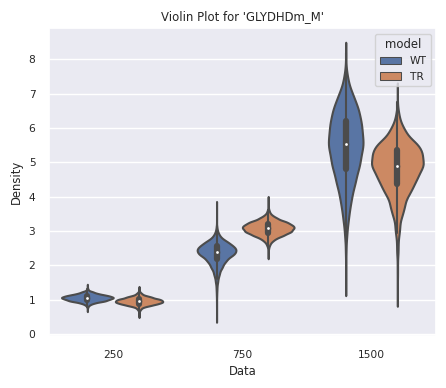

(<Figure size 500x400 with 1 Axes>,
 <Axes: title={'center': "Violin Plot for 'GLYDHDm_M'"}, xlabel='Data', ylabel='Density'>)

In [47]:
generate_single_column_violin_plot(merged_df, 'GLYDHDm_M', 'single_iteration')

#Gumagana ka naman why aren't you fcking working :(

/tmp/ipykernel_44554/1216912032.py:41: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  merged_df[['model', 'ppfd']] = merged_df['sample'].str.split('_', 1, expand=True)


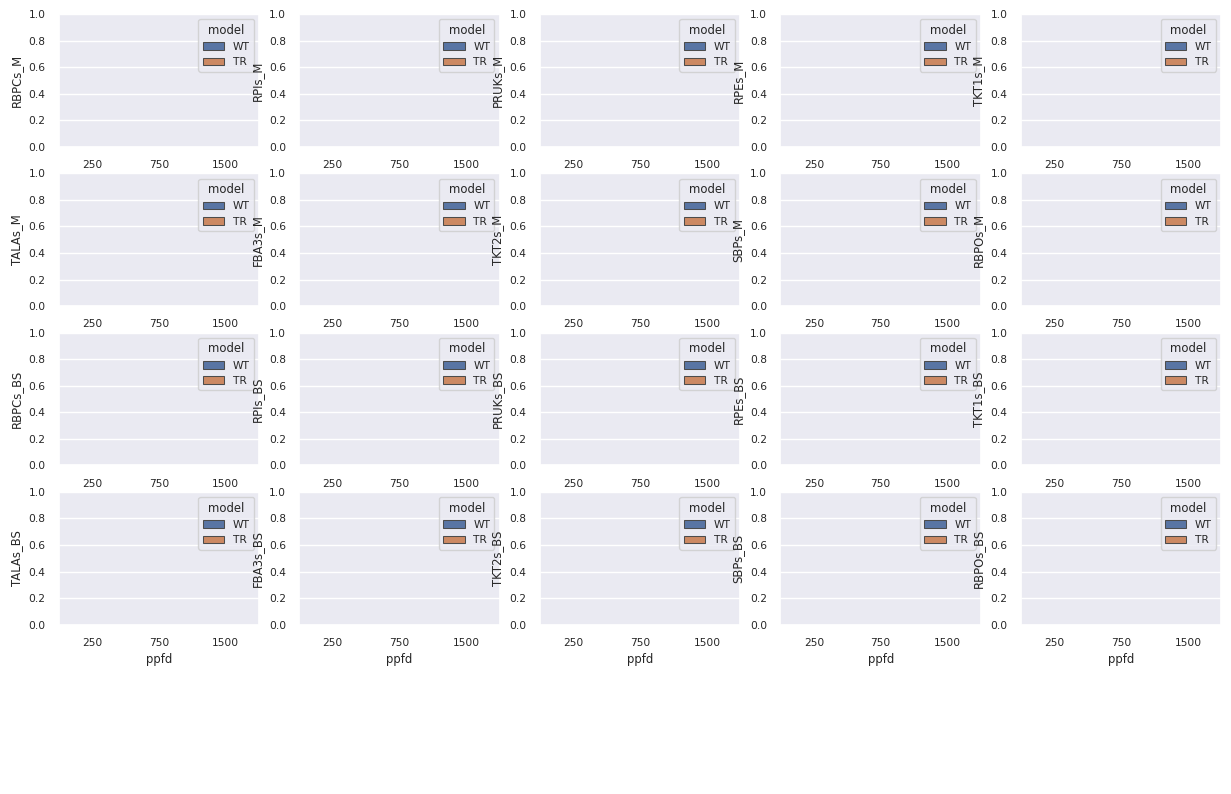

In [49]:
%matplotlib inline
merged_df = merge_dataframes(df_list, names)
test = generate_violin_plot(merged_df, 'Calvin cycle', filename='test_plot')
# generate_single_column_violin_plot(merged_df, 'GLYDHDm_M', 'single_iteration')

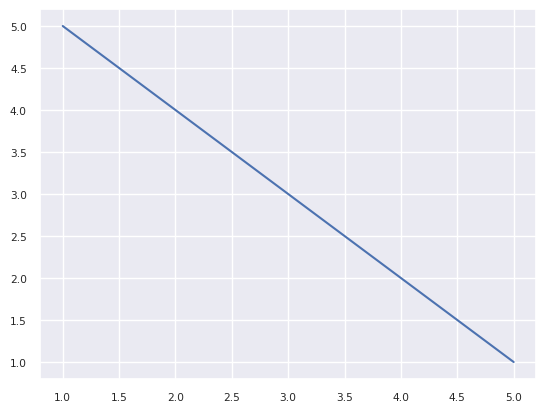

In [17]:
x = [1, 2, 3, 4, 5]
y = [5, 4, 3, 2, 1]

plt.plot(x, y)
plt.show()

In [ ]:
#Algorithm for generating plots based  on groups//


#Combine all the datasets adding the category 'WT and TR' as a column 'model' //

#Get the list of groups per reaction //
#Obtain the size of the gridspec needed by finding nearest square to the list //

#Obtain the flux ranges to add error bars to the violin plot signifying the low and high ranges using FVA//





#Iterate over the list, generate violin plots showing WT and TR models across the 3 light conditions //
#Add hue with 'model' as column from dataframe and 'light_condition' as x and the predicted flux values as y



#Algorithm for generating plots based  on groups//


#Get the list of groups per reaction //
#Obtain the size of the gridspec needed by finding nearest square to the list

#Obtain the flux ranges to add error bars to the violin plot signifying the low and high ranges using FVA//

#Combine all the datasets adding the category 'WT and TR' as a column 'model'//





#Iterate over the list, generate violin plots showing WT and TR models across the 3 light conditions 
    Almost done but for some reason it doesn't show
#Add hue with 'model' as column from dataframe and 'light_condition' as x and the predicted flux values as y



In [ ]:
#Add another plot for PLasmodesmatal transport

Findings for the heat plot

I don't think the heatplot of the log2 fold changes is too informative considering that the flux ranges are the actual meat of the analysis.

What I should do is to prepare plots for all groups instead?



Inferences based on filtered heatmap:

- Significantly differential fluxes in the Glycolysis module in the Bundle sheath compartment. Is it due to the supply of Triose Phosphates from the Mesophyll Cell?
- No significant perturbations seen in M Cell Calvin Cycle module.
- RPSII flux seen to be higher in TR rice than in WT -- indicative of change in CEF/LEF flow





Hmm. Interesting results. It shows that fluxes have become more decoupled in the low light regimens compared with medium and high light regimens when comparing results between parametrizations (WT and TR), at a threshold value of 0.001.
